<a href="https://colab.research.google.com/github/veruizr/ML_Doc/blob/main/Kaggle_competition/KaggleMLM2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#March Machine Learning Mania 2025
##Forecast the 2025 NCAA Basketball Tournaments

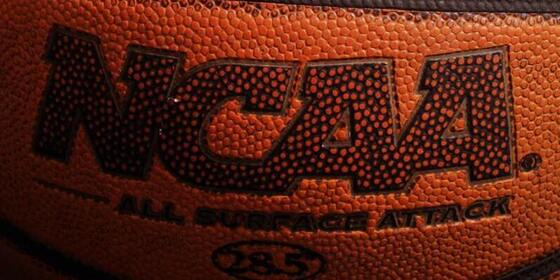

## 1.Análisis del Problema
El reto consiste en predecir el resultado de los partidos del torneo NCAA masculino de baloncesto, generalmente como una probabilidad de victoria para un equipo sobre otro. Los datos principales disponibles son los resultados compactos de la temporada regular, que incluyen los siguientes campos relevantes:


*   Season: Año de la temporada

*   DayNum: Día de la temporada
*   WTeamID, LTeamID: IDs de los equipos ganador y perdedor

*   WScore, LScore: Puntuaciones de ganador y perdedor

*   WLoc: Localización del ganador (Home/Away/Neutral)

*   NumOT: Número de prórrogas

El archivo de submission requiere una predicción para cada enfrentamiento posible, identificados por un ID único.

##2. Preprocesamiento de Datos
Se plantea la métrica para cada equipo basada en el rendimiento de la temporada regular, a partir del cálculo del "rating" de cada equipo usando el promedio de victorias y el número de victorias.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# Cargar datos de resultados de temporada regular y submission de ejemplo
results = pd.read_csv('MRegularSeasonCompactResults.csv')
sample_sub = pd.read_csv('SampleSubmissionStage2.csv')


#3. Crear características por equipo a partir de los resultados y generar estadisticas

In [4]:
# Crear features por equipo
def get_team_stats(results):
    stats = {}
    for team_col, opp_col, score_col, opp_score_col in [
        ('WTeamID', 'LTeamID', 'WScore', 'LScore'),
        ('LTeamID', 'WTeamID', 'LScore', 'WScore')
    ]:
        group = results.groupby(team_col)
        stats[f'{team_col}_wins'] = group.size()
        stats[f'{team_col}_points'] = group[score_col].sum()
        stats[f'{team_col}_opp_points'] = group[opp_score_col].sum()
        stats[f'{team_col}_games'] = group.size()
    # Unir y crear DataFrame
    df = pd.DataFrame({
        'TeamID': stats['WTeamID_wins'].index,
        'Wins': stats['WTeamID_wins'].values,
        'Losses': stats['LTeamID_wins'].values,
        'PointsFor': stats['WTeamID_points'].values + stats['LTeamID_points'].values,
        'PointsAgainst': stats['WTeamID_opp_points'].values + stats['LTeamID_opp_points'].values,
        'Games': stats['WTeamID_games'].values + stats['LTeamID_games'].values
    })
    df['WinPct'] = df['Wins'] / df['Games']
    df['AvgPoints'] = df['PointsFor'] / df['Games']
    df['AvgAllowed'] = df['PointsAgainst'] / df['Games']
    return df

team_stats = get_team_stats(results)


# 3. Crear Dataset de Entrenamiento
Se construye un dataset de partidos históricos para entrenar el modelo.

In [5]:
def build_training_set(results, team_stats):
    # Solo partidos de la temporada regular
    games = results.copy()
    games['Team1'] = np.minimum(games['WTeamID'], games['LTeamID'])
    games['Team2'] = np.maximum(games['WTeamID'], games['LTeamID'])
    games['Team1Win'] = (games['WTeamID'] < games['LTeamID']).astype(int)

    features = []
    for _, row in games.iterrows():
        t1 = team_stats[team_stats['TeamID'] == row['Team1']].iloc[0]
        t2 = team_stats[team_stats['TeamID'] == row['Team2']].iloc[0]
        feat = {
            'Team1_WinPct': t1['WinPct'],
            'Team2_WinPct': t2['WinPct'],
            'Team1_AvgPoints': t1['AvgPoints'],
            'Team2_AvgPoints': t2['AvgPoints'],
            'Team1_AvgAllowed': t1['AvgAllowed'],
            'Team2_AvgAllowed': t2['AvgAllowed'],
            'Diff_WinPct': t1['WinPct'] - t2['WinPct'],
            'Diff_AvgPoints': t1['AvgPoints'] - t2['AvgPoints'],
            'Diff_AvgAllowed': t1['AvgAllowed'] - t2['AvgAllowed'],
            'Target': row['Team1Win']
        }
        features.append(feat)
    return pd.DataFrame(features)

train_df = build_training_set(results, team_stats)


#4. Entrenamiento del Modelo

In [6]:
X = train_df.drop('Target', axis=1)
y = train_df['Target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMClassifier(n_estimators=100)
model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 75277, number of negative: 79067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2239
[LightGBM] [Info] Number of data points in the train set: 154344, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487722 -> initscore=-0.049121
[LightGBM] [Info] Start training from score -0.049121


LGBMClassifier()

#5.Generación de predicciones

In [7]:
def parse_id(id_str):
    season, t1, t2 = map(int, id_str.split('_'))
    return t1, t2

def make_features_for_submission(sample_sub, team_stats):
    features = []
    for id_str in sample_sub['ID']:
        t1, t2 = parse_id(id_str)
        # Si no hay stats, asignar valores neutros
        t1_stats = team_stats[team_stats['TeamID'] == t1]
        t2_stats = team_stats[team_stats['TeamID'] == t2]
        if t1_stats.empty or t2_stats.empty:
            feat = {k: 0 for k in [
                'Team1_WinPct', 'Team2_WinPct', 'Team1_AvgPoints', 'Team2_AvgPoints',
                'Team1_AvgAllowed', 'Team2_AvgAllowed', 'Diff_WinPct', 'Diff_AvgPoints', 'Diff_AvgAllowed'
            ]}
        else:
            t1 = t1_stats.iloc[0]
            t2 = t2_stats.iloc[0]
            feat = {
                'Team1_WinPct': t1['WinPct'],
                'Team2_WinPct': t2['WinPct'],
                'Team1_AvgPoints': t1['AvgPoints'],
                'Team2_AvgPoints': t2['AvgPoints'],
                'Team1_AvgAllowed': t1['AvgAllowed'],
                'Team2_AvgAllowed': t2['AvgAllowed'],
                'Diff_WinPct': t1['WinPct'] - t2['WinPct'],
                'Diff_AvgPoints': t1['AvgPoints'] - t2['AvgPoints'],
                'Diff_AvgAllowed': t1['AvgAllowed'] - t2['AvgAllowed'],
            }
        features.append(feat)
    return pd.DataFrame(features)

X_test = make_features_for_submission(sample_sub, team_stats)


#6. Preparar archivo de predicciones en el formato de envío de la competencia

In [8]:
preds = model.predict_proba(X_test)[:,1]
sample_sub['Pred'] = preds
sample_sub[['ID', 'Pred']].to_csv('submission.csv', index=False)
